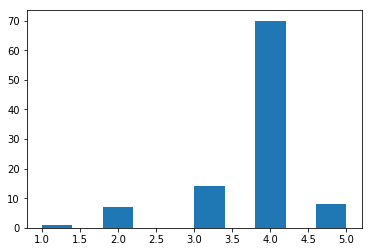

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from sklearn.metrics import confusion_matrix

labels = scipy.io.loadmat('labels.mat')
features = scipy.io.loadmat('features.mat')
hip_images = scipy.io.loadmat('hip_images.mat')

# just need the array from the dictionary
hip_images = hip_images['hip_images']
features = features['features']
labels = labels['labels']

# roll array so first axis represent number of instances
hip_images = np.rollaxis(hip_images, 2)

# convert string features to usable inputs for NN
features = [list(example) for example in features]
features = np.asarray(features).astype(np.int)

labels = np.array(labels).astype(np.int)

plt.hist(labels)
# labels start at 1, make them start at 0 then one-hot
labels = labels - 1
y_one_hot = np.zeros((labels.size, labels.max()+1))
y_one_hot[np.arange(labels.size), labels] = 1

### Train Neural Net with 5 selected features

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# use given features to train
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
for train_index, test_index in skf.split(hip_images, labels):
    
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    clf1 = MLPClassifier(max_iter=500, random_state=1)
    clf1.fit(X_train, y_train)
    scores = clf1.score(X_test, y_test)
    preds = clf1.predict(X_test)
    print(confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test, axis=1)))
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("acc: " + str(scores))


/home/anon/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
/home/anon/anaconda2/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[[ 0  1  0  0  0]
 [ 0  1  0  0  0]
 [ 0  0  2  0  0]
 [ 0  0  0 18  0]
 [ 0  0  2  0  2]]
acc: 0.846153846154
[[ 0  0  0  1  0]
 [ 0  0  0  0  0]
 [ 0  2  4  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  2]]
acc: 0.884615384615
[[ 0  0  0  0  0]
 [ 0  1  1  0  0]
 [ 0  1  2  1  0]
 [ 1  0  0 16  0]
 [ 0  0  0  0  2]]
acc: 0.84
[[ 0  1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  2]]
acc: 0.95652173913


### Train Neural Net with pixels as features

In [3]:
# use raw pixels to train MLP
X = hip_images.reshape((hip_images.shape[0], -1))

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, labels):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]
    
    clf2 = MLPClassifier(max_iter=500, random_state=1)
    clf2.fit(X_train, y_train)
    scores = clf2.score(X_test, y_test)
    preds = clf2.predict(X_test)
    print(confusion_matrix(np.argmax(preds, axis=1), np.argmax(y_test, axis=1)))
#     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("acc: " + str(scores))


[[ 0  2  4 18  2]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
acc: 0.0
[[ 0  0  0  5  0]
 [ 0  0  0  0  0]
 [ 0  2  4 13  2]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
acc: 0.153846153846
[[ 1  2  3 17  2]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
acc: 0.0
[[ 0  1  3 14  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  3  2]
 [ 0  0  0  0  0]]
acc: 0.130434782609


### Train CNN with 2 Convolution and Kernel size 3

In [4]:
# CNN in Keras

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 32
num_classes = 5
epochs = 20

# input image dimensions
img_rows, img_cols = 90, 90

# the data, shuffled and split between train and test sets
# split = 75
(x_train, y_train) = (hip_images[train_index, :, :], labels[train_index])
(x_test, y_test) = (hip_images[test_index, :, :], labels[test_index])

print(x_train.shape, x_test.shape)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
((77, 90, 90), (23, 90, 90))
('x_train shape:', (77, 90, 90, 1))
(77, 'train samples')
(23, 'test samples')
Train on 77 samples, validate on 23 samples
Epoch 1/20
77/77 [==============================] - 6s - loss: 1.3954 - acc: 0.4545 - val_loss: 0.9063 - val_acc: 0.7391
Epoch 2/20
77/77 [==============================] - 2s - loss: 1.1006 - acc: 0.6883 - val_loss: 1.1226 - val_acc: 0.6957
Epoch 3/20
77/77 [==============================] - 2s - loss: 1.1140 - acc: 0.6364 - val_loss: 0.9392 - val_acc: 0.7391
Epoch 4/20
77/77 [==============================] - 2s - loss: 1.1240 - acc: 0.6883 - val_loss: 0.8805 - val_acc: 0.7391
Epoch 5/20
77/77 [==============================] - 2s - loss: 1.1051 - acc: 0.6883 - val_loss: 0.9135 - val_acc: 0.7391
Epoch 6/20
77/77 [==============================] - 2s - loss: 0.9477 - acc: 0.7013 - val_loss: 0.9063 - val_acc: 0.7391
Epoch 7/20
77/77 [==============================] -

In [5]:
print(y_pred.shape)
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
np.argmax(y_train, axis=1)

(23, 5)
[[ 0  0  1  0]
 [ 0  0  3  0]
 [ 0  0 17  0]
 [ 0  0  2  0]]


array([2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       1, 1, 4, 3, 3, 0, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3,
       3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 4, 2, 3])

### Train CNN with 2 Convolution and Kernel size 5

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 77 samples, validate on 23 samples
Epoch 1/20
77/77 [==============================] - 7s - loss: 1.4409 - acc: 0.4156 - val_loss: 0.9350 - val_acc: 0.7391
Epoch 2/20
77/77 [==============================] - 2s - loss: 1.2096 - acc: 0.6364 - val_loss: 0.9783 - val_acc: 0.7391
Epoch 3/20
77/77 [==============================] - 2s - loss: 0.9951 - acc: 0.6753 - val_loss: 1.0124 - val_acc: 0.7391
Epoch 4/20
77/77 [==============================] - 2s - loss: 1.1091 - acc: 0.6883 - val_loss: 0.9022 - val_acc: 0.7391
Epoch 5/20
77/77 [==============================] - 2s - loss: 0.9938 - acc: 0.6883 - val_loss: 1.0723 - val_acc: 0.7391
Epoch 6/20
77/77 [==============================] - 2s - loss: 1.0181 - acc: 0.6623 - val_loss: 0.8870 - val_acc: 0.7391
Epoch 7/20
77/77 [==============================] - 2s - loss: 0.9158 - acc: 0.6753 - val_loss: 1.0651 - val_acc: 0.7391
Epoch 8/20
77/77 [==============================] - 2s - loss: 0.8993 - acc: 0.7143 - val_loss: 0.8714 - val_

### Train CNN with 3 Convolution and Kernel size 3 and learning rate 0.5

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# adding new layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# change learning rate
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=0.5),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 77 samples, validate on 23 samples
Epoch 1/20
77/77 [==============================] - 3s - loss: 1.5229 - acc: 0.3766 - val_loss: 1.2335 - val_acc: 0.7391
Epoch 2/20
77/77 [==============================] - 1s - loss: 1.1419 - acc: 0.6883 - val_loss: 1.1815 - val_acc: 0.7391
Epoch 3/20
77/77 [==============================] - 1s - loss: 1.0746 - acc: 0.6883 - val_loss: 0.9060 - val_acc: 0.7391
Epoch 4/20
77/77 [==============================] - 2s - loss: 1.1224 - acc: 0.6883 - val_loss: 0.9318 - val_acc: 0.7391
Epoch 5/20
77/77 [==============================] - 2s - loss: 1.0948 - acc: 0.6883 - val_loss: 1.0648 - val_acc: 0.7391
Epoch 6/20
77/77 [==============================] - 1s - loss: 1.0461 - acc: 0.6883 - val_loss: 1.1201 - val_acc: 0.7391
Epoch 7/20
77/77 [==============================] - 1s - loss: 1.0448 - acc: 0.6883 - val_loss: 0.9837 - val_acc: 0.7391
Epoch 8/20
77/77 [==============================] - 1s - loss: 0.9886 - acc: 0.6883 - val_loss: 1.0376 - val_